In [1]:
import pandas as pd 
import numpy as np 
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns', None)

import geopandas as gpd 
import contextily as cx
from shapely.geometry import Polygon
from libpysal.cg.alpha_shapes import alpha_shape_auto
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans, OPTICS
from scipy.cluster.hierarchy import dendrogram, linkage

import sys
sys.path.append("../")
try:
    from esda.adbscan import ADBSCAN, get_cluster_boundary, remap_lbls
# This below can be removed once A-DBSCAN is merged into `esda`
except:
    print("Import from local folder...")
    import sys
    sys.path.append("../esda")
    from adbscan import ADBSCAN, get_cluster_boundary, remap_lbls

pd.options.mode.chained_assignment = None

In [2]:
global mi_files, wi_files, mn_files, info_files, dir

dir = os.getcwd()
dir = dir + '\\SitesData'

mi_files = [f for f in listdir(dir+'\\MI') if isfile(join(dir+'\\MI', f))]
wi_files = [f for f in listdir(dir+'\\WI') if isfile(join(dir+'\\WI', f))]
mn_files = [f for f in listdir(dir+'\\MN') if isfile(join(dir+'\\MN', f))]

info_files = {'MI': mi_files[-1], 'WI': wi_files[-1], 'MN': mn_files[-1]} 

In [3]:
print(dir)

c:\Users\lucam\OneDrive - nd.edu\Paleon\SitesData


In [4]:
class State:
    def __init__(self, sites, state):
        self.sites = sites
        self.state = state 

    def get_sites_info(self):
        return pd.read_csv(dir+'\\'+self.state+'\\'+info_files[self.state])

    def get_sites_paths(self):
        return self.sites

michigan = State(mi_files, 'MI')
minnesota = State(mn_files, 'MN')
wisconsin = State(wi_files, 'WI')

wisconsin.get_sites_info().head()

,siteid,sitename,latitude,longitude,datasetid,datasettype,ageoldest,ageyoungest
0,196,Hells Kitchen Lake,46.186120,-89.702730,3131,pollen,2040.00,2.0
1,196,Hells Kitchen Lake,46.186120,-89.702730,48818,pollen,10546.00,-49.0
2,197,Lake Mary,46.250000,-89.900000,3473,pollen,11604.00,231.0
3,281,Blue Mounds Creek,43.083333,-89.866667,287,pollen,11810.00,17.0
4,306,Brown Lake,45.779780,-89.492470,313,pollen,112.75,-32.1


In [5]:
class Site:
    def __init__(self, siteid, info_df, state):
        self.siteid = siteid
        self.info_df = info_df
        self.state = state 

    def get_dataset_ids(self):
        return self.info_df[self.info_df['siteid']==self.siteid]['datasetid'].tolist()

    def get_paths(self):
        datasetids = self.get_dataset_ids()
        paths = []
        for d in datasetids:
            paths.append('\\dataset'+str(d)+'_site'+str(self.siteid)+'.csv')

        return paths 

    def get_dfs(self):
        paths = self.get_paths()
        dfs = []
        for p in paths:
            dfs.append(pd.read_csv(dir+'\\'+str(self.state)+p))
        return dfs

    def pollen_data(self):
        dfs = self.get_dfs()
        pollen_df = []
        for df in dfs:
            temp = df.iloc[5:]
            temp['element'] = temp['element'].fillna('pollen')
            pollen_df.append(temp[temp['element']=='pollen'])
        return pollen_df 

    def get_dating_types(self):
        dfs = self.get_dfs()
        types = []
        for df in dfs:
            types_temp = df[['group']].dropna()
            types_temp = types_temp.loc[types_temp['group'].str.contains("BP", case=False)]
            if len(types_temp['group'].str.contains("alendar", case=False))>0 and len(types_temp['group'].str.contains("radiocarbon", case=False))>0:
                types.append('both')
            elif len(types_temp['group'].str.contains("alendar", case=False))>0:
                types.append('cal')
            elif len(types_temp['group'].str.contains("radiocarbon", case=False))>0:
                types.append('rc')
            else:
                types.append('none')

        return types

    def get_timestamps(self):
        types = self.get_dating_types()
        df = self.pollen_data()
        ts = []
        for i in range(len(types)):
            if types[i] == 'rc' or types[i] == 'both':
                temp = df[i][df[i]['group'].str.contains('radiocarbon', case=False)]
            elif types[i] == 'cal':
                temp = df[i][df[i]['group'].str.contains('cal', case=False)]
            else:
                ts.append([])
                continue
            temp = temp.drop(columns={'name','group','element','units','context'})
            temp = temp.T

            for c in temp.columns:
                temp[str(c)+'_'] = temp[c].str.split('/').str[1]
                temp.drop(columns={c}, inplace=True)
            temp = temp.replace('-', np.nan)
            temp = temp.replace('--', np.nan)
            for c in temp.columns:
                temp[c] = np.floor(pd.to_numeric(temp[c], errors='coerce')).astype('Int64')
            ts.append(temp.mean(axis=1))

        return ts

    def get_latlon(self):
        latlon = self.info_df
        latlon = latlon[latlon['siteid'] == self.siteid]
        return {'lat': latlon.latitude.values[0], 'lon': latlon.longitude.values[0]}

    def get_timeseries(self):

        pollen_dfs = self.pollen_data()
        time = self.get_timestamps()
        timeseries = []
        for i, pol in enumerate(pollen_dfs):

            pol = pol[pol['group'].str.contains('BP')==False]
            taxa = pol['name']
            pol.drop(columns={'name','group','element','units','context'}, inplace=True)
            
            if len(time[i]) > 0:
                pol.columns = time[i]
            else:
                continue
            pol['t'] = taxa
            pol.set_index('t', drop=True, inplace=True)
            pol = pol.T
            pol['lat'] = self.get_latlon()['lat']
            pol['lon'] = self.get_latlon()['lon']

            timeseries.append(pol)
        ts_all = pd.DataFrame()
        for ts in timeseries:
            ts_all = pd.concat([ts_all, ts], join='outer')

        return ts_all.sort_index()

In [6]:
michigan_pollen = pd.DataFrame()
for s in michigan.get_sites_info()['siteid'].tolist():
    temp_site = Site(s, michigan.get_sites_info(), 'MI')
    temp_df = temp_site.get_timeseries()
    michigan_pollen = pd.concat([michigan_pollen, temp_df], join='outer')

In [7]:
minnesota_pollen = pd.DataFrame()
for s in minnesota.get_sites_info()['siteid'].tolist():
    temp_site = Site(s, minnesota.get_sites_info(), 'MN')
    temp_df = temp_site.get_timeseries()
    minnesota_pollen = pd.concat([minnesota_pollen, temp_df], join='outer')

In [8]:
wisconsin_pollen = pd.DataFrame()
for s in wisconsin.get_sites_info()['siteid'].tolist():
    temp_site = Site(s, wisconsin.get_sites_info(), 'WI')
    temp_df = temp_site.get_timeseries()
    wisconsin_pollen = pd.concat([wisconsin_pollen, temp_df], join='outer')

In [9]:
wisconsin_pollen

t,Abies,Acer,Alnus,Amaranthaceae,Ambrosia-type,Angiospermae undiff. (herbs),Artemisia,Asteraceae undiff.,Betula,Carya,Corylus,Cupressaceae,Cyperaceae,Ericaceae,Fagus,Fraxinus,Ilex,Juglans,Larix,Liquidambar,Myrica,Ostrya/Carpinus,Picea,Pinus subg. Pinus,Pinus subg. Strobus,Pinus undiff.,Plantago,Platanus,Poaceae,Populus,Quercus,Rumex,Salix,Spermatophyta undiff. (trees),Tilia,Tsuga,Ulmus,lat,lon,Acer rubrum,Acer saccharum,Acer sp.,Alnus incana,Alnus viridis subsp. crispa,Ambrosia,Apiaceae,Arceuthobium,Asteraceae,Brassicaceae,Caryophyllaceae,Ceanothus,Drosera,Ephedra,Fabaceae,Fraxinus americana,Fraxinus nigra,Juglans cinerea,Juglans nigra,Lamiaceae,Liliaceae,Malvaceae,Myriophyllum,Nuphar,Pinus,Polygonum,Potamogeton,Ribes-type,Rosaceae,Sagittaria,Sarcobatus,Sparganium,Typha latifolia,Acer negundo,Acer saccharinum,Asteroideae undiff.,Celtis,Fraxinus nigra-type,Fraxinus pennsylvanica/F. americana-type,Iva annua,Potamogetonaceae,Typha/Sparganium undiff.,Cephalanthus,Chamaedaphne calyculata,Cornus,Cupressaceae undiff.,Dalea purpurea,Ericaceae undiff.,Humulus,Juniperus-type,Polygalaceae,Prunus,Ranunculus,Thalictrum,Typha/Sparganium,Utricularia,Vitis,Castanea,Morus,Urtica-type,Amaranthaceae undiff.,Brasenia schreberi,Polygala,Portulaca,Rhamnus,Rhus,Rosaceae undiff.,Rubus,Sarcobatus vermiculatus,Solanaceae,Urtica,Viburnum,Xanthium,Amorpha-type,Cannabaceae sensu stricto,Caprifoliaceae sensu lato,Fabaceae undiff.,Iva,Rhamnaceae/Vitaceae,Sparganium-type,Urticaceae,Pinus banksiana/P. resinosa,Pinus strobus,Elaeagnus,Filipendula,Juniperus/Thuja,Nymphaea,Ostrya,Polygonum sensu lato,Potentilla,Ranunculaceae undiff.,Rubiaceae,Shepherdia,Juniperus,Nymphaeaceae undiff.,Onagraceae,Typha,Acer saccharinum-type,Acer saccharum-type,Acer spicatum,Acer undiff.,Alnus incana-type,Alnus undiff.,Alnus viridis-type,Caltha,Fraxinus pennsylvanica-type,Fraxinus undiff.,Galium,Menyanthes trifoliata,Myricaceae,Pinaceae undiff.,Buxus,Crassulaceae,Euphorbia,Gentiana,Hypericum,Nyssa,Polemoniaceae,Ribes,Saxifraga-type,Campanula,Clusiaceae,Fagopyrum,Saxifragaceae,Scrophulariaceae,Solanum,Alnus cf. A. incana,Bidens-type,Chenopodium-type,Cichorioideae,Cornus canadensis,Cyclachaena xanthiifolia-type,Gaultheria procumbens,Humulus/Cannabis sativa,Iva annua-type,Juglans undiff.,Plantago major,Populus balsamifera-type,Populus tremuloides-type,Potentilla-type,Prunus americana-type,Rhododendron subsect. Ledum/Chamaedaphne calyculata,Rubus chamaemorus,Sarracenia,cf. Rhamnus alnifolia,Caltha-type,Dalea,Fabaceae cf. Melilotus,Geum,Laportea,Poaceae undiff.,Ranunculus flabellaris-type,Toxicodendron radicans-type,Zea mays,cf. Amorpha,cf. Viburnum lentago,Pinus det. P. banksiana/P. resinosa,Pinus det. P. strobus,Acer pensylvanicum,Anacardiaceae,Aquifoliaceae,Crataegus-type,Gleditsia,Lemnoideae,Moraceae undiff.,Oxyria digyna,Poaceae (Cerealia),Prunus/Sorbus,Pyrus-type,Rhamnaceae/Vitaceae undiff.,Salsola,Spermatophyta undiff. (aquatics),Spermatophyta undiff. (shrubs),Iva undiff.,Polygonaceae undiff.,Impatiens,Iridaceae,Primulaceae,Sambucus,Abies balsamea,Acalypha cf. A. rhomboidea,Acer nigrum,Alnus viridis,Amorpha fruticosa,Castanea dentata,Caulophyllum thalictroides,Comptonia peregrina,Cornus cf. C. rugosa,Cornus sericea,Cyclachaena xanthiifolia,Fagus grandifolia,Fraxinus pennsylvanica,Hydrophyllum,Laportea-type,Larix laricina,Micranthes cf. M. virginiensis,Monotropa uniflora,Morus rubra,Myosotis,Parietaria-type,Phlox cf. P. hoodii,Platanus occidentalis,Populus balsamifera,Prunus americana,Saxifraga undiff.,Taxus canadensis,Thalictrum dasycarpum-type,Thalictrum dioicum-type,Thalictrum venulosum-type,Tidestromia lanuginosa,Tilia americana,Triodanis,Tsuga canadensis,Viburnum opulus,Vitis cf. V. aestivalis,cf. Arabis glabra,cf. Hedysarum,cf. Lobelia siphilitica,cf. Pedicularis,Rhamnaceae,Vaccinium,Valeriana,Alnus (pentaporate),Alnus (tetraporate),Betulaceae undiff.,Cyperaceae undiff.,Eriophorum,Fraxinus (tetracolpate),Fraxinus (tricolpate),Lemna,Myrica/Comptonia peregrina,Thuja,Typha angu

In [15]:
all_pollen = pd.concat([michigan_pollen, minnesota_pollen, wisconsin_pollen], join='outer').reset_index()
all_pollen = all_pollen[all_pollen['index'].notna()]
all_pollen = all_pollen.sort_values(by='index')
all_pollen.rename(columns={'index':'RC_yrs'}, inplace=True)
all_pollen.reset_index(drop=True, inplace=True)
all_pollen = all_pollen.fillna(0)
all_pollen = all_pollen.tail(len(all_pollen)-1)
all_pollen = all_pollen.astype('float')
#all_pollen = all_pollen.rename(columns={'lon': "AA_lon", "lat": "AA_lat", 'RC_yrs': "AA_RC_yrs"})
all_pollen = all_pollen.reindex(sorted(all_pollen.columns), axis=1)
all_pollen.shape

(11827, 795)

In [11]:
'''
info = all_pollen.drop(columns=['AA_RC_yrs','AA_lon','AA_lat']).describe().T
info = info.sort_values(by='std', ascending=False)
info.head(15)
'''

,count,mean,std,min,25%,50%,75%,max
t,,,,,,,,
Poaceae,11827.0,41.911981,365.191669,0.0,0.0,4.0,19.0,9999.0
Pinus undiff.,11827.0,62.509491,92.441361,0.0,0.0,24.0,92.0,844.0
Pinus,11827.0,29.462459,77.667771,0.0,0.0,0.0,16.0,884.0
Picea,11827.0,24.881796,74.650822,0.0,1.0,3.0,11.0,1380.0
Quercus,11827.0,52.136890,58.400667,0.0,13.0,28.0,73.0,601.0
Pinus banksiana/P. resinosa,11827.0,13.543908,50.484624,0.0,0.0,0.0,0.0,954.0
Betula,11827.0,41.475184,49.325589,0.0,10.0,25.0,57.0,720.0
Cyperaceae,11827.0,16.907443,38.808616,0.0,1.0,5.0,16.0,778.0
Pinus subg. Strobus,11827.0,17.149869,36.697034,0.0,0.0,0.0,18.0,489.0


In [16]:
all_pollen = all_pollen[all_pollen != 99999]
all_pollen.iloc[:,3:] = all_pollen.iloc[:,3:][all_pollen.iloc[:,3:] > 0]
all_pollen.shape 

(11827, 795)

In [13]:
all_pollen['RC_yrs'] = pd.cut(all_pollen.RC_yrs, bins=[*range(-100,47200, 100)]).cat.codes.astype('int')

all_pollen['lon_lat'] = all_pollen['lon'].astype('str') + all_pollen['lat'].astype('str')
lon_lat = all_pollen[['lon','lat','lon_lat']]
all_pollen = all_pollen.drop(columns=['lon','lat']).groupby(['RC_yrs','lon_lat']).sum()
all_pollen

AttributeError: 'DataFrame' object has no attribute 'RC_yrs'

In [ ]:
all_pollen.reset_index(level=0, inplace=True)
all_pollen

t,RC_yrs,Abies,Acer negundo,Acer rubrum,Acer saccharinum,Acer saccharum,Alnus,Amaranthaceae,Ambrosia,Apiaceae,Artemisia,Asteroideae undiff.,Betula,Brasenia schreberi,Carya,Caryophyllaceae,Corylus,Cupressaceae,Cyperaceae,Ericaceae,Fagus,Fraxinus nigra-type,Fraxinus pennsylvanica/F. americana-type,Ilex,Juglans nigra,Larix,Myrica,Myriophyllum,Ostrya/Carpinus,Picea,Pinus subg. Pinus,Pinus subg. Strobus,Pinus undiff.,Platanus,Poaceae,Populus,Potamogetonaceae,Quercus,Rhamnus,Rhus,Rosaceae,Salix,Thalictrum,Tilia,Tsuga,Typha/Sparganium,Ulmus,Acer saccharinum-type,Acer saccharum-type,Acer undiff.,Alnus undiff.,Alnus viridis-type,Amaranthaceae undiff.,Ambrosia-type,Angiospermae undiff. (herbs),Fraxinus,Juglans,Morus,Nuphar,Nymphaea,Pinus,Rumex,Sarcobatus vermiculatus,Spermatophyta undiff. (shrubs),Spermatophyta undiff. (trees),Taxus,Acer,Asteraceae undiff.,Fabaceae,Lamiaceae,Menyanthes trifoliata,Plantago,Rhamnaceae/Vitaceae,Cephalanthus,Cornus,Galium,Polygonum sensu lato,Saxifragaceae,Urtica-type,Nyssa,Poaceae (Cerealia),Poaceae undiff.,Celtis,Polygonaceae undiff.,Ephedra,Shepherdia,Acer spicatum,Ceanothus,Cichorioideae,Ericaceae undiff.,Fraxinus nigra,Fraxinus pennsylvanica,Juglans cinerea,Juniperus/Thuja,Liquidambar,Plantago lanceolata,Sambucus,Shepherdia canadensis,Typha angustifolia/Sparganium,Typha latifolia,Vaccinium,Viburnum,Vitis,Campanulaceae,Fraxinus pennsylvanica-type,Hippuris vulgaris,Spermatophyta undiff. (aquatics),Iva annua,Sagittaria,Typha/Sparganium undiff.,Xanthium,Brassicaceae,Cornus canadensis,Drosera,Ranunculus,Zea,Castanea,Primulaceae,Aquifoliaceae,Fraxinus (tetracolpate),Fraxinus (tricolpate),Fraxinus undiff.,Nymphaeaceae undiff.,Ostrya,Pinus banksiana/P. resinosa,Pinus strobus-type,Populus balsamifera,Populus grandidentata-type,Thuja plicata-type,Typha angustifolia,Myricaceae,Nemopanthus,Juglans undiff.,Rosaceae undiff.,Sanguisorba,Elaeagnus,Potentilla-type,Acer pensylvanicum,Alnus (pentaporate),Alnus (tetraporate),Alnus (triporate),Eriocaulon,Humulus,Linnaea borealis,Potamogeton,Potentilla,Prunus,Typha,Ilex/Nemopanthus,Persicaria lapathifolia,Polygonum,Typha (tetrad),Utricularia,Alnus incana,Arceuthobium,Asteroideae,Fraxinus americana,Menyanthes,Myricaceae undiff.,Elodea,Eupatorium,Juniperus,Pinus banksiana,Pinus strobus,Fraxinus americana-type,Asteraceae,Brasenia,Alnus viridis subsp. crispa,Chenopodiaceae sensu stricto,Cupressaceae/Taxaceae undiff.,Liliaceae,Ribes,Alnus incana-type,Bidens-type,Celtis/Maclura-type,Cornus canadensis-type,Cornus undiff.,Ilex-type,Ilex/Nemopanthus undiff.,Iva annua-type,Mentha,Myrica-type,Phlox,Populus tremuloides,Primula farinosa-type,Sparganium-type,Taxus canadensis,Urtica,Ranunculaceae undiff.,Iris,Persicaria amphibia,Ranunculaceae,Brassica,Chenopodium,Heteranthera,Iva,Salsola,Suaeda,Asteraceae (high spine),Asteraceae (low spine),Lemna,Rubus,Sparganium,Cyclachaena xanthiifolia,Cupressaceae undiff.,Helianthus,Nyssa sylvatica,Suaeda calceoliformis,Zizania aquatica,Lotus,Betulaceae undiff.,Dalea,Ericaceae-type,Humulus-type,Persicaria lapathifolia-type,Pinaceae undiff.,Prunus-type,Rhamnaceae undiff.,Xanthium-type,Moraceae,Myrica/Comptonia,Nymphaeaceae,Urticaceae,Vitaceae,Onagraceae,Acer negundo-type,Dalea purpurea,Picea glauca,Picea mariana,Populus deltoides-type,Tilia americana,Cupressaceae/Taxaceae,Lemnoideae,Eriogonum,Polygonaceae,Sarcobatus,Caltha,Castanea dentata,Celtis occidentalis,Chenopodium-type,Dalea purpurea-type,Fagus grandifolia,Larix laricina,Liquidambar styraciflua,Platanus occidentalis,Rubiaceae,Thuja-type,Tsuga canadensis,Picea undiff.,Caltha palustris,Hippuris,Papaveraceae,Ephedra viridis-type,Populus undiff.,Ranunculaceae (tricolpate) undiff.,Stuckenia,Ilex verticillata,Plantago undiff.,Shepherdia argentea,Amorpha,Dalea candida-type,Ephedra nevadensis-type,Ephedra torreyana-type,Persicaria maculosa-type,Zea mays,Alnus viridis,Euphorbia,Fabaceae undiff.,Sanguisorba canadensis,Epilobium,Abies balsamea,Aquilapollenites,Boraginaceae cf. Mertensia paniculata,Calla pal

In [ ]:
lon_lat.set_index('lon_lat', inplace=True)
lon_lat.drop_duplicates(inplace=True)
lon_lat

t,lon,lat
lon_lat,,
-89.5942843.800155,-89.594280,43.800155
-89.69965546.188945,-89.699655,46.188945
-92.0398546.11935,-92.039850,46.119350
-88.31698847.129415,-88.316988,47.129415
-86.79751546.33153,-86.797515,46.331530
...,...,...
-94.11666746.116667,-94.116667,46.116667
-92.57333346.503333,-92.573333,46.503333
-92.71666746.416667,-92.716667,46.416667


In [ ]:
df = all_pollen.join(lon_lat, on='lon_lat', how='outer')
df

t,RC_yrs,Abies,Acer negundo,Acer rubrum,Acer saccharinum,Acer saccharum,Alnus,Amaranthaceae,Ambrosia,Apiaceae,Artemisia,Asteroideae undiff.,Betula,Brasenia schreberi,Carya,Caryophyllaceae,Corylus,Cupressaceae,Cyperaceae,Ericaceae,Fagus,Fraxinus nigra-type,Fraxinus pennsylvanica/F. americana-type,Ilex,Juglans nigra,Larix,Myrica,Myriophyllum,Ostrya/Carpinus,Picea,Pinus subg. Pinus,Pinus subg. Strobus,Pinus undiff.,Platanus,Poaceae,Populus,Potamogetonaceae,Quercus,Rhamnus,Rhus,Rosaceae,Salix,Thalictrum,Tilia,Tsuga,Typha/Sparganium,Ulmus,Acer saccharinum-type,Acer saccharum-type,Acer undiff.,Alnus undiff.,Alnus viridis-type,Amaranthaceae undiff.,Ambrosia-type,Angiospermae undiff. (herbs),Fraxinus,Juglans,Morus,Nuphar,Nymphaea,Pinus,Rumex,Sarcobatus vermiculatus,Spermatophyta undiff. (shrubs),Spermatophyta undiff. (trees),Taxus,Acer,Asteraceae undiff.,Fabaceae,Lamiaceae,Menyanthes trifoliata,Plantago,Rhamnaceae/Vitaceae,Cephalanthus,Cornus,Galium,Polygonum sensu lato,Saxifragaceae,Urtica-type,Nyssa,Poaceae (Cerealia),Poaceae undiff.,Celtis,Polygonaceae undiff.,Ephedra,Shepherdia,Acer spicatum,Ceanothus,Cichorioideae,Ericaceae undiff.,Fraxinus nigra,Fraxinus pennsylvanica,Juglans cinerea,Juniperus/Thuja,Liquidambar,Plantago lanceolata,Sambucus,Shepherdia canadensis,Typha angustifolia/Sparganium,Typha latifolia,Vaccinium,Viburnum,Vitis,Campanulaceae,Fraxinus pennsylvanica-type,Hippuris vulgaris,Spermatophyta undiff. (aquatics),Iva annua,Sagittaria,Typha/Sparganium undiff.,Xanthium,Brassicaceae,Cornus canadensis,Drosera,Ranunculus,Zea,Castanea,Primulaceae,Aquifoliaceae,Fraxinus (tetracolpate),Fraxinus (tricolpate),Fraxinus undiff.,Nymphaeaceae undiff.,Ostrya,Pinus banksiana/P. resinosa,Pinus strobus-type,Populus balsamifera,Populus grandidentata-type,Thuja plicata-type,Typha angustifolia,Myricaceae,Nemopanthus,Juglans undiff.,Rosaceae undiff.,Sanguisorba,Elaeagnus,Potentilla-type,Acer pensylvanicum,Alnus (pentaporate),Alnus (tetraporate),Alnus (triporate),Eriocaulon,Humulus,Linnaea borealis,Potamogeton,Potentilla,Prunus,Typha,Ilex/Nemopanthus,Persicaria lapathifolia,Polygonum,Typha (tetrad),Utricularia,Alnus incana,Arceuthobium,Asteroideae,Fraxinus americana,Menyanthes,Myricaceae undiff.,Elodea,Eupatorium,Juniperus,Pinus banksiana,Pinus strobus,Fraxinus americana-type,Asteraceae,Brasenia,Alnus viridis subsp. crispa,Chenopodiaceae sensu stricto,Cupressaceae/Taxaceae undiff.,Liliaceae,Ribes,Alnus incana-type,Bidens-type,Celtis/Maclura-type,Cornus canadensis-type,Cornus undiff.,Ilex-type,Ilex/Nemopanthus undiff.,Iva annua-type,Mentha,Myrica-type,Phlox,Populus tremuloides,Primula farinosa-type,Sparganium-type,Taxus canadensis,Urtica,Ranunculaceae undiff.,Iris,Persicaria amphibia,Ranunculaceae,Brassica,Chenopodium,Heteranthera,Iva,Salsola,Suaeda,Asteraceae (high spine),Asteraceae (low spine),Lemna,Rubus,Sparganium,Cyclachaena xanthiifolia,Cupressaceae undiff.,Helianthus,Nyssa sylvatica,Suaeda calceoliformis,Zizania aquatica,Lotus,Betulaceae undiff.,Dalea,Ericaceae-type,Humulus-type,Persicaria lapathifolia-type,Pinaceae undiff.,Prunus-type,Rhamnaceae undiff.,Xanthium-type,Moraceae,Myrica/Comptonia,Nymphaeaceae,Urticaceae,Vitaceae,Onagraceae,Acer negundo-type,Dalea purpurea,Picea glauca,Picea mariana,Populus deltoides-type,Tilia americana,Cupressaceae/Taxaceae,Lemnoideae,Eriogonum,Polygonaceae,Sarcobatus,Caltha,Castanea dentata,Celtis occidentalis,Chenopodium-type,Dalea purpurea-type,Fagus grandifolia,Larix laricina,Liquidambar styraciflua,Platanus occidentalis,Rubiaceae,Thuja-type,Tsuga canadensis,Picea undiff.,Caltha palustris,Hippuris,Papaveraceae,Ephedra viridis-type,Populus undiff.,Ranunculaceae (tricolpate) undiff.,Stuckenia,Ilex verticillata,Plantago undiff.,Shepherdia argentea,Amorpha,Dalea candida-type,Ephedra nevadensis-type,Ephedra torreyana-type,Persicaria maculosa-type,Zea mays,Alnus viridis,Euphorbia,Fabaceae undiff.,Sanguisorba canadensis,Epilobium,Abies balsamea,Aquilapollenites,Boraginaceae cf. Mertensia paniculata,Calla pal

In [ ]:
df.reset_index(drop=True, inplace=True)

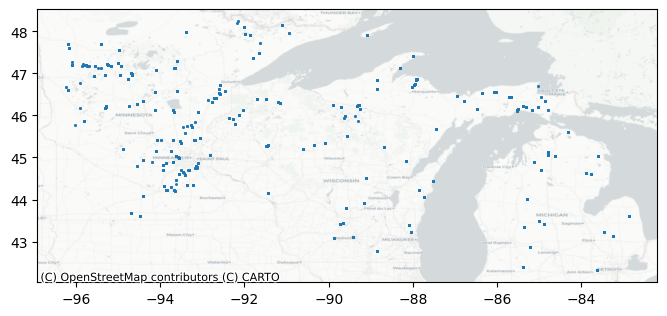

In [ ]:
X_gpd = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs='epsg:4326').to_crs(epsg=4326)

ax = X_gpd.plot(markersize=0.7, figsize=(8,8))
cx.add_basemap(ax, crs=X_gpd.crs.to_string(), source=cx.providers.CartoDB.Positron);

In [ ]:
X_gpd.head(3)

t,RC_yrs,Abies,Acer negundo,Acer rubrum,Acer saccharinum,Acer saccharum,Alnus,Amaranthaceae,Ambrosia,Apiaceae,Artemisia,Asteroideae undiff.,Betula,Brasenia schreberi,Carya,Caryophyllaceae,Corylus,Cupressaceae,Cyperaceae,Ericaceae,Fagus,Fraxinus nigra-type,Fraxinus pennsylvanica/F. americana-type,Ilex,Juglans nigra,Larix,Myrica,Myriophyllum,Ostrya/Carpinus,Picea,Pinus subg. Pinus,Pinus subg. Strobus,Pinus undiff.,Platanus,Poaceae,Populus,Potamogetonaceae,Quercus,Rhamnus,Rhus,Rosaceae,Salix,Thalictrum,Tilia,Tsuga,Typha/Sparganium,Ulmus,Acer saccharinum-type,Acer saccharum-type,Acer undiff.,Alnus undiff.,Alnus viridis-type,Amaranthaceae undiff.,Ambrosia-type,Angiospermae undiff. (herbs),Fraxinus,Juglans,Morus,Nuphar,Nymphaea,Pinus,Rumex,Sarcobatus vermiculatus,Spermatophyta undiff. (shrubs),Spermatophyta undiff. (trees),Taxus,Acer,Asteraceae undiff.,Fabaceae,Lamiaceae,Menyanthes trifoliata,Plantago,Rhamnaceae/Vitaceae,Cephalanthus,Cornus,Galium,Polygonum sensu lato,Saxifragaceae,Urtica-type,Nyssa,Poaceae (Cerealia),Poaceae undiff.,Celtis,Polygonaceae undiff.,Ephedra,Shepherdia,Acer spicatum,Ceanothus,Cichorioideae,Ericaceae undiff.,Fraxinus nigra,Fraxinus pennsylvanica,Juglans cinerea,Juniperus/Thuja,Liquidambar,Plantago lanceolata,Sambucus,Shepherdia canadensis,Typha angustifolia/Sparganium,Typha latifolia,Vaccinium,Viburnum,Vitis,Campanulaceae,Fraxinus pennsylvanica-type,Hippuris vulgaris,Spermatophyta undiff. (aquatics),Iva annua,Sagittaria,Typha/Sparganium undiff.,Xanthium,Brassicaceae,Cornus canadensis,Drosera,Ranunculus,Zea,Castanea,Primulaceae,Aquifoliaceae,Fraxinus (tetracolpate),Fraxinus (tricolpate),Fraxinus undiff.,Nymphaeaceae undiff.,Ostrya,Pinus banksiana/P. resinosa,Pinus strobus-type,Populus balsamifera,Populus grandidentata-type,Thuja plicata-type,Typha angustifolia,Myricaceae,Nemopanthus,Juglans undiff.,Rosaceae undiff.,Sanguisorba,Elaeagnus,Potentilla-type,Acer pensylvanicum,Alnus (pentaporate),Alnus (tetraporate),Alnus (triporate),Eriocaulon,Humulus,Linnaea borealis,Potamogeton,Potentilla,Prunus,Typha,Ilex/Nemopanthus,Persicaria lapathifolia,Polygonum,Typha (tetrad),Utricularia,Alnus incana,Arceuthobium,Asteroideae,Fraxinus americana,Menyanthes,Myricaceae undiff.,Elodea,Eupatorium,Juniperus,Pinus banksiana,Pinus strobus,Fraxinus americana-type,Asteraceae,Brasenia,Alnus viridis subsp. crispa,Chenopodiaceae sensu stricto,Cupressaceae/Taxaceae undiff.,Liliaceae,Ribes,Alnus incana-type,Bidens-type,Celtis/Maclura-type,Cornus canadensis-type,Cornus undiff.,Ilex-type,Ilex/Nemopanthus undiff.,Iva annua-type,Mentha,Myrica-type,Phlox,Populus tremuloides,Primula farinosa-type,Sparganium-type,Taxus canadensis,Urtica,Ranunculaceae undiff.,Iris,Persicaria amphibia,Ranunculaceae,Brassica,Chenopodium,Heteranthera,Iva,Salsola,Suaeda,Asteraceae (high spine),Asteraceae (low spine),Lemna,Rubus,Sparganium,Cyclachaena xanthiifolia,Cupressaceae undiff.,Helianthus,Nyssa sylvatica,Suaeda calceoliformis,Zizania aquatica,Lotus,Betulaceae undiff.,Dalea,Ericaceae-type,Humulus-type,Persicaria lapathifolia-type,Pinaceae undiff.,Prunus-type,Rhamnaceae undiff.,Xanthium-type,Moraceae,Myrica/Comptonia,Nymphaeaceae,Urticaceae,Vitaceae,Onagraceae,Acer negundo-type,Dalea purpurea,Picea glauca,Picea mariana,Populus deltoides-type,Tilia americana,Cupressaceae/Taxaceae,Lemnoideae,Eriogonum,Polygonaceae,Sarcobatus,Caltha,Castanea dentata,Celtis occidentalis,Chenopodium-type,Dalea purpurea-type,Fagus grandifolia,Larix laricina,Liquidambar styraciflua,Platanus occidentalis,Rubiaceae,Thuja-type,Tsuga canadensis,Picea undiff.,Caltha palustris,Hippuris,Papaveraceae,Ephedra viridis-type,Populus undiff.,Ranunculaceae (tricolpate) undiff.,Stuckenia,Ilex verticillata,Plantago undiff.,Shepherdia argentea,Amorpha,Dalea candida-type,Ephedra nevadensis-type,Ephedra torreyana-type,Persicaria maculosa-type,Zea mays,Alnus viridis,Euphorbia,Fabaceae undiff.,Sanguisorba canadensis,Epilobium,Abies balsamea,Aquilapollenites,Boraginaceae cf. Mertensia paniculata,Calla pal

In [70]:
from shapely.ops import cascaded_union, unary_union

epa_path = 'C:/Users/lucam/OneDrive - nd.edu/Paleon/SitesData/Eco_regions_I'
epa1 = gpd.read_file(epa_path + '/Ecological_Regions_of_North_America___Level_1.shp')
epa1 = gpd.GeoDataFrame(epa1, geometry=epa1.geometry, crs='epsg:4326').to_crs(epsg=4326)
epa1_5 = epa1[epa1['NA_L1CODE'] == '5']
epa1_8 = epa1[epa1['NA_L1CODE'] == '8']
epa1_9 = epa1[epa1['NA_L1CODE'] == '9']

In [72]:
boundary5 = gpd.GeoSeries(unary_union(epa1_5.geometry), crs='epsg:4326').values[0]
boundary8 = gpd.GeoSeries(unary_union(epa1_8.geometry), crs='epsg:4326').values[0]
boundary8 = gpd.GeoSeries(unary_union(epa1_8.geometry), crs='epsg:4326').values[0]

In [76]:
points = X_gpd['geometry']
region = []
for i, p in enumerate(points):
    if (i+1) % 50 == 0:
        print('Checked {} out of {}'.format(i+1, len(points)))
    if boundary5.contains(p):
        region.append(5)
    elif boundary8.contains(p):
        region.append(8)
    else:
        region.append(9) 
print('Checked {} out of {}'.format(i+1, len(points)))

Checked 50 out of 6547
Checked 100 out of 6547
Checked 150 out of 6547
Checked 200 out of 6547
Checked 250 out of 6547
Checked 300 out of 6547
Checked 350 out of 6547
Checked 400 out of 6547
Checked 450 out of 6547
Checked 500 out of 6547
Checked 550 out of 6547
Checked 600 out of 6547
Checked 650 out of 6547
Checked 700 out of 6547
Checked 750 out of 6547
Checked 800 out of 6547
Checked 850 out of 6547
Checked 900 out of 6547
Checked 950 out of 6547
Checked 1000 out of 6547
Checked 1050 out of 6547
Checked 1100 out of 6547
Checked 1150 out of 6547
Checked 1200 out of 6547
Checked 1250 out of 6547
Checked 1300 out of 6547
Checked 1350 out of 6547
Checked 1400 out of 6547
Checked 1450 out of 6547
Checked 1500 out of 6547
Checked 1550 out of 6547
Checked 1600 out of 6547
Checked 1650 out of 6547
Checked 1700 out of 6547
Checked 1750 out of 6547
Checked 1800 out of 6547
Checked 1850 out of 6547
Checked 1900 out of 6547
Checked 1950 out of 6547
Checked 2000 out of 6547
Checked 2050 out of 

In [78]:
X_gpd['region'] = np.array(region)
X_gpd

t,RC_yrs,Abies,Acer negundo,Acer rubrum,Acer saccharinum,Acer saccharum,Alnus,Amaranthaceae,Ambrosia,Apiaceae,Artemisia,Asteroideae undiff.,Betula,Brasenia schreberi,Carya,Caryophyllaceae,Corylus,Cupressaceae,Cyperaceae,Ericaceae,Fagus,Fraxinus nigra-type,Fraxinus pennsylvanica/F. americana-type,Ilex,Juglans nigra,Larix,Myrica,Myriophyllum,Ostrya/Carpinus,Picea,Pinus subg. Pinus,Pinus subg. Strobus,Pinus undiff.,Platanus,Poaceae,Populus,Potamogetonaceae,Quercus,Rhamnus,Rhus,Rosaceae,Salix,Thalictrum,Tilia,Tsuga,Typha/Sparganium,Ulmus,Acer saccharinum-type,Acer saccharum-type,Acer undiff.,Alnus undiff.,Alnus viridis-type,Amaranthaceae undiff.,Ambrosia-type,Angiospermae undiff. (herbs),Fraxinus,Juglans,Morus,Nuphar,Nymphaea,Pinus,Rumex,Sarcobatus vermiculatus,Spermatophyta undiff. (shrubs),Spermatophyta undiff. (trees),Taxus,Acer,Asteraceae undiff.,Fabaceae,Lamiaceae,Menyanthes trifoliata,Plantago,Rhamnaceae/Vitaceae,Cephalanthus,Cornus,Galium,Polygonum sensu lato,Saxifragaceae,Urtica-type,Nyssa,Poaceae (Cerealia),Poaceae undiff.,Celtis,Polygonaceae undiff.,Ephedra,Shepherdia,Acer spicatum,Ceanothus,Cichorioideae,Ericaceae undiff.,Fraxinus nigra,Fraxinus pennsylvanica,Juglans cinerea,Juniperus/Thuja,Liquidambar,Plantago lanceolata,Sambucus,Shepherdia canadensis,Typha angustifolia/Sparganium,Typha latifolia,Vaccinium,Viburnum,Vitis,Campanulaceae,Fraxinus pennsylvanica-type,Hippuris vulgaris,Spermatophyta undiff. (aquatics),Iva annua,Sagittaria,Typha/Sparganium undiff.,Xanthium,Brassicaceae,Cornus canadensis,Drosera,Ranunculus,Zea,Castanea,Primulaceae,Aquifoliaceae,Fraxinus (tetracolpate),Fraxinus (tricolpate),Fraxinus undiff.,Nymphaeaceae undiff.,Ostrya,Pinus banksiana/P. resinosa,Pinus strobus-type,Populus balsamifera,Populus grandidentata-type,Thuja plicata-type,Typha angustifolia,Myricaceae,Nemopanthus,Juglans undiff.,Rosaceae undiff.,Sanguisorba,Elaeagnus,Potentilla-type,Acer pensylvanicum,Alnus (pentaporate),Alnus (tetraporate),Alnus (triporate),Eriocaulon,Humulus,Linnaea borealis,Potamogeton,Potentilla,Prunus,Typha,Ilex/Nemopanthus,Persicaria lapathifolia,Polygonum,Typha (tetrad),Utricularia,Alnus incana,Arceuthobium,Asteroideae,Fraxinus americana,Menyanthes,Myricaceae undiff.,Elodea,Eupatorium,Juniperus,Pinus banksiana,Pinus strobus,Fraxinus americana-type,Asteraceae,Brasenia,Alnus viridis subsp. crispa,Chenopodiaceae sensu stricto,Cupressaceae/Taxaceae undiff.,Liliaceae,Ribes,Alnus incana-type,Bidens-type,Celtis/Maclura-type,Cornus canadensis-type,Cornus undiff.,Ilex-type,Ilex/Nemopanthus undiff.,Iva annua-type,Mentha,Myrica-type,Phlox,Populus tremuloides,Primula farinosa-type,Sparganium-type,Taxus canadensis,Urtica,Ranunculaceae undiff.,Iris,Persicaria amphibia,Ranunculaceae,Brassica,Chenopodium,Heteranthera,Iva,Salsola,Suaeda,Asteraceae (high spine),Asteraceae (low spine),Lemna,Rubus,Sparganium,Cyclachaena xanthiifolia,Cupressaceae undiff.,Helianthus,Nyssa sylvatica,Suaeda calceoliformis,Zizania aquatica,Lotus,Betulaceae undiff.,Dalea,Ericaceae-type,Humulus-type,Persicaria lapathifolia-type,Pinaceae undiff.,Prunus-type,Rhamnaceae undiff.,Xanthium-type,Moraceae,Myrica/Comptonia,Nymphaeaceae,Urticaceae,Vitaceae,Onagraceae,Acer negundo-type,Dalea purpurea,Picea glauca,Picea mariana,Populus deltoides-type,Tilia americana,Cupressaceae/Taxaceae,Lemnoideae,Eriogonum,Polygonaceae,Sarcobatus,Caltha,Castanea dentata,Celtis occidentalis,Chenopodium-type,Dalea purpurea-type,Fagus grandifolia,Larix laricina,Liquidambar styraciflua,Platanus occidentalis,Rubiaceae,Thuja-type,Tsuga canadensis,Picea undiff.,Caltha palustris,Hippuris,Papaveraceae,Ephedra viridis-type,Populus undiff.,Ranunculaceae (tricolpate) undiff.,Stuckenia,Ilex verticillata,Plantago undiff.,Shepherdia argentea,Amorpha,Dalea candida-type,Ephedra nevadensis-type,Ephedra torreyana-type,Persicaria maculosa-type,Zea mays,Alnus viridis,Euphorbia,Fabaceae undiff.,Sanguisorba canadensis,Epilobium,Abies balsamea,Aquilapollenites,Boraginaceae cf. Mertensia paniculata,Calla pal

In [79]:
X_gpd.to_file('C:/Users/lucam/OneDrive - nd.edu/Paleon/SitesData/pollen_data.shp')

C:\Users\lucam\AppData\Local\Temp\ipykernel_25256\498218423.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  X_gpd.to_file('C:/Users/lucam/OneDrive - nd.edu/Paleon/SitesData/pollen_data.shp')


In [68]:
X = all_pollen[all_pollen.RC_yrs <= 0]

# clustering = DBSCAN(eps=.95, min_samples=3, n_jobs=-1).fit(np.array(X.drop(columns=['lon','lat'])))
clustering = KMeans(n_clusters=2).fit(np.array(X))
X['label'] = clustering.labels_
X['label'].unique()

c:\Users\lucam\Anaconda3\envs\py11\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 0])

In [69]:
#X = all_pollen[all_pollen.RC_yrs <= 20]
db_ll = geopandas.GeoDataFrame(X, geometry=geopandas.points_from_xy(X.lon, X.lat), crs='epsg:4326')
db = db_ll.to_crs(epsg=4326)

''' 
db["X"] = db.geometry.x
db["Y"] = db.geometry.y
adbs = ADBSCAN(1.2, 3, pct_exact=0.2, reps=100, keep_solus=True)
np.random.seed(1234)
adbs.fit(db)

ax = db.assign(lbls=adbs.votes["lbls"])\
       .plot(column="lbls",
             categorical=True,
             markersize=2.5,
             figsize=(12, 12))
cx.add_basemap(ax, crs=db.crs.to_string(), source=cx.providers.CartoDB.Positron);
''' 

' \ndb["X"] = db.geometry.x\ndb["Y"] = db.geometry.y\nadbs = ADBSCAN(1.2, 3, pct_exact=0.2, reps=100, keep_solus=True)\nnp.random.seed(1234)\nadbs.fit(db)\n\nax = db.assign(lbls=adbs.votes["lbls"])       .plot(column="lbls",\n             categorical=True,\n             markersize=2.5,\n             figsize=(12, 12))\ncx.add_basemap(ax, crs=db.crs.to_string(), source=cx.providers.CartoDB.Positron);\n'

In [211]:
''' 
polys = get_cluster_boundary(adbs.votes["lbls"], db, crs=db.crs)
ax = polys.plot(alpha=0.3, figsize=(10,5))
cx.add_basemap(ax, crs=polys.crs.to_string(), source=cx.providers.CartoDB.Positron);
''' 

' \npolys = get_cluster_boundary(adbs.votes["lbls"], db, crs=db.crs)\nax = polys.plot(alpha=0.3, figsize=(10,5))\ncx.add_basemap(ax, crs=polys.crs.to_string(), source=cx.providers.CartoDB.Positron);\n'

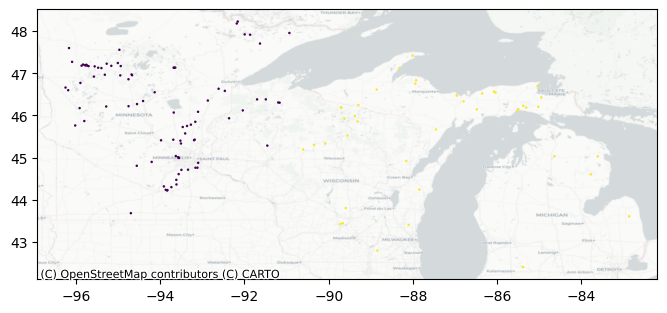

In [70]:
ax = db.plot(markersize=0.6, c=db.label, label=db.label, figsize=(8,5))
cx.add_basemap(ax, crs=db.crs.to_string(), source=cx.providers.CartoDB.Positron);

In [17]:
X = all_pollen[all_pollen.RC_yrs <= 0]

clustering = DBSCAN(eps=1.2, min_samples=5, n_jobs=-1).fit(np.array(X))
#clustering = SpectralClustering(n_clusters=3, assign_labels='cluster_qr', random_state=0, n_neighbors=5).fit(np.array(X))
X['label'] = clustering.labels_
X['label'].unique()

array([ 2,  0,  1, -1], dtype=int64)

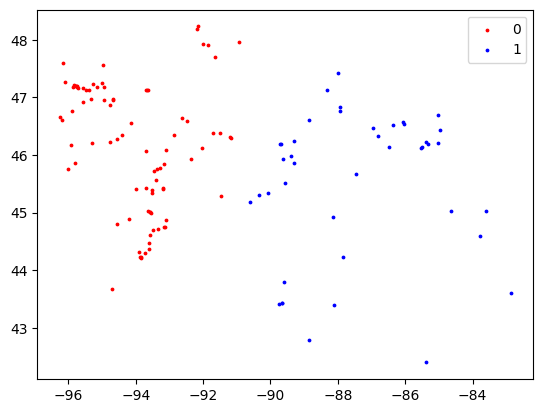

In [71]:
cdict = {0:'red', 1:'blue'}

fig, ax = plt.subplots()

for g in np.unique(clustering.labels_):
    ix = X[X['label'] == g]
    ax.scatter(ix['lon'], ix['lat'], c=cdict[g], label=g, s=3)

ax.legend();